In [ ]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names
num_classes = len(target_names)


In [ ]:
X = X / 255.0
X = np.expand_dims(X, axis=-1)
y = to_categorical(y, num_classes=num_classes)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - accuracy: 0.2168 - loss: 2.7381 - val_accuracy: 0.0736 - val_loss: 1.9489
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.3711 - loss: 1.9332 - val_accuracy: 0.0698 - val_loss: 2.0003
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.4248 - loss: 1.7719 - val_accuracy: 0.0736 - val_loss: 2.1091
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.5122 - loss: 1.4600 - val_accuracy: 0.0736 - val_loss: 2.1558
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.6314 - loss: 1.1589 - val_accuracy: 0.0736 - val_loss: 2.4174
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.6651 - loss: 1.0126 - val_accuracy: 0.0736 - val_loss: 2.5745
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.7543 - loss: 0.7886 - val_accuracy: 0.1822 - val_loss: 2.5934
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.7694 - loss: 0.6831 - val_accuracy: 0.1822 - 

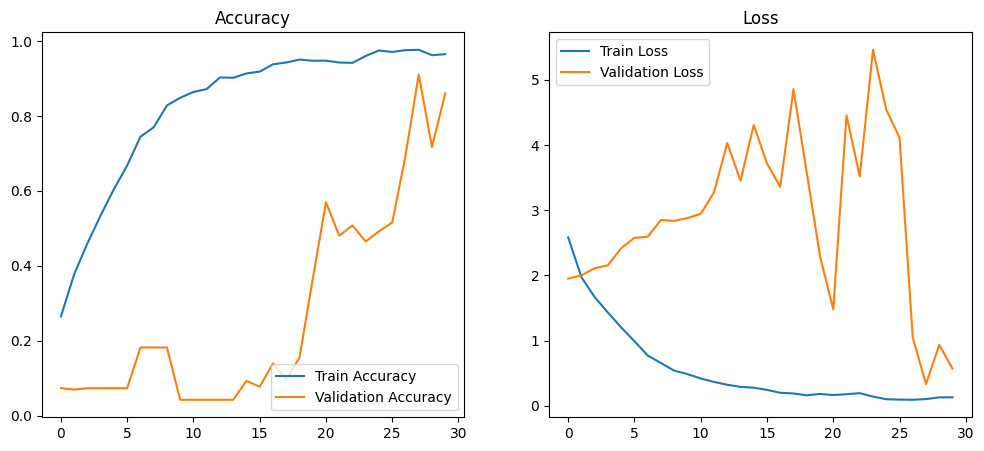

In [ ]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(X.shape[1], X.shape[2], 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

model.save("face_recognition_model.h5")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")
plt.show()


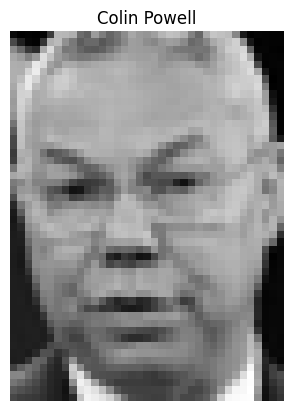

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


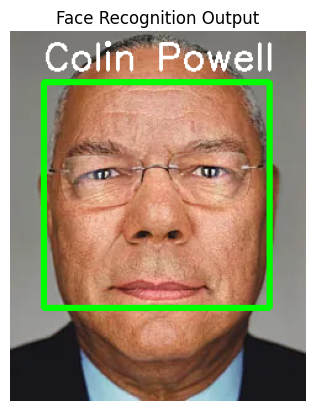

In [ ]:
# Load trained model
model = tf.keras.models.load_model("/content/face_recognition_model.h5")

# Initialize OpenCV Face Detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def recognize_face(image_path):
    image = cv2.imread(image_path)  # Load image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face_roi = gray[y:y+h, x:x+w]  # Extract face
        face_resized = cv2.resize(face_roi, (X.shape[1], X.shape[2])) / 255.0
        face_resized = np.expand_dims(face_resized, axis=[0, -1])

        # Predict face label
        prediction = model.predict(face_resized)
        predicted_label = np.argmax(prediction)

        # Draw Bounding Box & Label
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)
        cv2.putText(image, target_names[predicted_label], (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Convert BGR to RGB for display
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Face Recognition Output")
    plt.show()



# Load the LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Get the target names and labels
target_names = lfw_people.target_names
labels = lfw_people.target

# Find the index corresponding to Colin Powell
colin_powell_index = list(target_names).index('Colin Powell')

# Find the index of the first image of Colin Powell
first_colin_powell_image_index = next((i for i, label in enumerate(labels) if label == colin_powell_index), None)

# Plot the image if found
if first_colin_powell_image_index is not None:
    plt.imshow(lfw_people.images[first_colin_powell_image_index], cmap='gray')
    plt.title("Colin Powell")
    plt.axis('off')  # Hide axes
    plt.show()


# Test on an image
test_image_path = "/content/test.webp"  # Change this to your test image
recognize_face(test_image_path)


In [ ]:
from sklearn.datasets import fetch_lfw_people

# Load the LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Get the target names (names of people in the dataset)
target_names = lfw_people.target_names

# Find the index corresponding to Colin Powell
colin_powell_index = list(target_names).index('Colin Powell')

# Get the labels (numerical representation of target names)
labels = lfw_people.target

# Count the number of images with Colin Powell's label
colin_powell_image_count = sum(1 for label in labels if label == colin_powell_index)

# Print the result
print(f"Number of Colin Powell photos in LFW: {colin_powell_image_count}")

Number of Colin Powell photos in LFW: 236
